## Win/Loss Rating Model Prediction

Load the model and make predictions

In [3]:
import requests
import pandas as pd
import numpy as np
import pymc3 as pm
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import norm
plt.style.use('fivethirtyeight')
%matplotlib inline

### Get a list of all CS Games

## Load Ratings Model

In [4]:
TEAM_SET = 'eslpl'

teams = np.load('saved_model/'+TEAM_SET+'/teams.npy')
maps = np.load('saved_model/'+TEAM_SET+'/maps.npy')
filt = np.load('saved_model/'+TEAM_SET+'/filter_teams.npy')
h_teams = pd.read_csv('hltv_csv/teams.csv')
h_teams = h_teams.set_index('ID').loc[teams]
h_teams.loc[7723, 'Name'] = 'Morior Invictus'
h_teams.loc[8241, 'Name'] = 'ex-Nitrious'
h_teams_filt = h_teams[h_teams.Name.isin(filt)]

def prep_pymc_model(n_teams, n_maps):
    with pm.Model() as rating_model:
        omega = pm.HalfCauchy('omega', 0.5)
        tau = pm.HalfCauchy('tau', 0.5)
        rating = pm.Normal('rating', 0, omega, shape=n_teams)
        theta_tilde = pm.Normal('rate_t', mu=0, sd=1, shape=(n_maps, n_teams))
        rating_map = pm.Deterministic('rating | map', rating + tau * theta_tilde)
        alpha = pm.Gamma('alpha', 10, 5)
        sigma = pm.HalfCauchy('sigma', 0.5, shape=n_maps)
    return rating_model

rating_model = prep_pymc_model(len(teams), len(maps))
trace = pm.backends.text.load('saved_model/'+TEAM_SET+'/trace', model=rating_model)

## Sample A test set

In [5]:
h_matches = pd.read_csv('hltv_csv/matchResults.csv').set_index('Match ID')
h_matches['Date'] = pd.to_datetime(h_matches.Date)
h_matches = h_matches[(h_matches.Date >= dt.datetime(2017,1,1)) &
         (h_matches['Team 1 ID'].isin(h_teams_filt.index)) &
         (h_matches['Team 2 ID'].isin(h_teams_filt.index))]
sample_valid_set = h_matches.sample(1000, replace=False)
sample_valid_set['Winner'] = sample_valid_set['Team 1 Score'] >= sample_valid_set['Team 2 Score']

In [6]:
sample_valid_set = sample_valid_set[['Date', 'Team 1 ID', 'Team 2 ID', 'Map', 'Winner']]

# Generate Predictions

In [13]:
def sig(x):
    return 1 / (1 + np.exp(-x))

from tqdm import tqdm_notebook

valid_set = []
t_rating = trace['rating']
t_ratingmap = trace['rating | map']
for i,v in tqdm_notebook(sample_valid_set.iterrows()):
    t1_ind = np.where(teams == v['Team 1 ID'])[0][0]; t2_ind = np.where(teams == v['Team 2 ID'])[0][0];
    m_ind = np.where(maps == v['Map'])[0][0]
    
    trace_1 = t_rating[:,t1_ind]; trace_2 = t_rating[:,t2_ind]
    diff = trace_1-trace_2
    p_wl = sig(diff)
    #wr_uncond = p_wl.mean()
    wr_uncond = np.percentile(p_wl, 40)
    
    trace_1 = t_ratingmap[:,m_ind,t1_ind]; trace_2 = t_ratingmap[:,m_ind,t2_ind]
    diff = trace_1-trace_2
    p_wl = sig(diff)
    #wr_cond = p_wl.mean()
    wr_cond = np.percentile(p_wl, 40)
    
    valid_set.append([int(v['Winner']), wr_uncond, wr_cond])
validation = np.array(valid_set)

A Jupyter Widget

Log Loss U: 0.64380
Log Loss C: 0.58392
CM Unconditional
[[ 0.6812749   0.3187251 ]
 [ 0.40763052  0.59236948]]
CM Conditional
[[ 0.70119522  0.29880478]
 [ 0.35943775  0.64056225]]


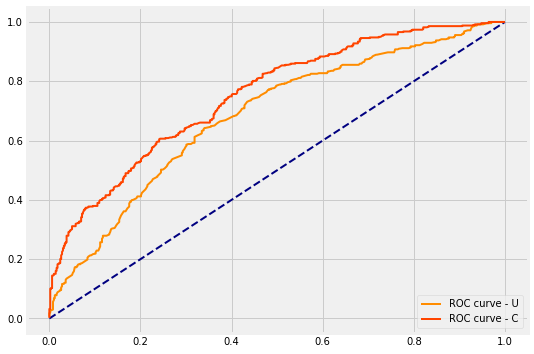

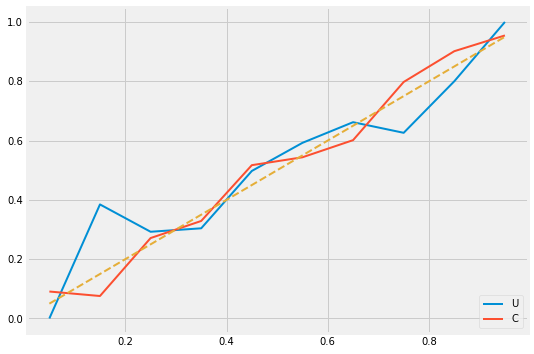

In [14]:
from sklearn.metrics import roc_curve, confusion_matrix, log_loss
print('Log Loss U: %.5f' % log_loss(validation[:,0], validation[:,1]))
print('Log Loss C: %.5f' % log_loss(validation[:,0], validation[:,2]))

fpr, tpr, tresh = roc_curve(validation[:,0], validation[:,1])
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve - U')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
fpr, tpr, tresh = roc_curve(validation[:,0], validation[:,2])
ax.plot(fpr, tpr, color='orangered', lw=2, label='ROC curve - C')
ax.legend(loc="lower right")

validation_binary = validation.copy()
validation_binary[:,1] = (validation_binary[:,1] > 0.5).astype(int)
validation_binary[:,2] = (validation_binary[:,2] > 0.5).astype(int)

cm = confusion_matrix(validation_binary[:,0], validation_binary[:,1])
print("CM Unconditional")
print(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
cm = confusion_matrix(validation_binary[:,0], validation_binary[:,2])
print("CM Conditional")
print(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])

bins = np.vstack([np.arange(0,1,0.1), np.arange(0.1,1.1,0.1)]).T
binned = {'U': [], 'C': []}
for r in bins:
    binned['U'].append(validation[(validation[:,1] >= r[0])&(validation[:,1] < r[1]),0].mean())
    binned['C'].append(validation[(validation[:,2] >= r[0])&(validation[:,2] < r[1]),0].mean())
    
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(bins.sum(axis=1)/2,binned['U'], lw=2, label='U')
ax.plot(bins.sum(axis=1)/2,binned['C'], lw=2, label='C')
ax.plot(bins.sum(axis=1)/2,bins.sum(axis=1)/2, lw=2, linestyle='--')
ax.legend(loc="lower right")


Log Loss U: 0.64254
Log Loss C: 0.58491
CM Unconditional
[[ 0.62549801  0.37450199]
 [ 0.33534137  0.66465863]]
CM Conditional
[[ 0.64741036  0.35258964]
 [ 0.32730924  0.67269076]]


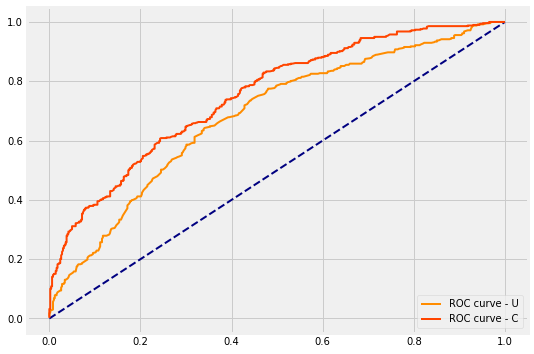

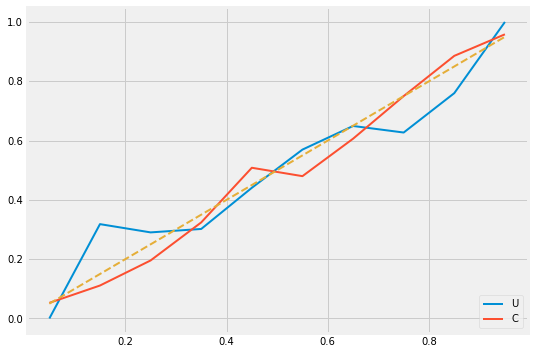

In [10]:
from sklearn.metrics import roc_curve, confusion_matrix, log_loss
print('Log Loss U: %.5f' % log_loss(validation[:,0], validation[:,1]))
print('Log Loss C: %.5f' % log_loss(validation[:,0], validation[:,2]))

fpr, tpr, tresh = roc_curve(validation[:,0], validation[:,1])
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve - U')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
fpr, tpr, tresh = roc_curve(validation[:,0], validation[:,2])
ax.plot(fpr, tpr, color='orangered', lw=2, label='ROC curve - C')
ax.legend(loc="lower right")

validation_binary = validation.copy()
validation_binary[:,1] = (validation_binary[:,1] > 0.5).astype(int)
validation_binary[:,2] = (validation_binary[:,2] > 0.5).astype(int)

cm = confusion_matrix(validation_binary[:,0], validation_binary[:,1])
print("CM Unconditional")
print(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
cm = confusion_matrix(validation_binary[:,0], validation_binary[:,2])
print("CM Conditional")
print(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])

bins = np.vstack([np.arange(0,1,0.1), np.arange(0.1,1.1,0.1)]).T
binned = {'U': [], 'C': []}
for r in bins:
    binned['U'].append(validation[(validation[:,1] >= r[0])&(validation[:,1] < r[1]),0].mean())
    binned['C'].append(validation[(validation[:,2] >= r[0])&(validation[:,2] < r[1]),0].mean())
    
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(bins.sum(axis=1)/2,binned['U'], lw=2, label='U')
ax.plot(bins.sum(axis=1)/2,binned['C'], lw=2, label='C')
ax.plot(bins.sum(axis=1)/2,bins.sum(axis=1)/2, lw=2, linestyle='--')
ax.legend(loc="lower right")


In [ ]:
sample_valid_set.reset_index(drop=True).to_csv('sample_valid_set.csv',index=False)